# Synthetic regression for entitlement counts

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline

Let's assume $\mu$ is a function of income:

We can draw a bunch of samples of income from a lognormal distribution as a starting point:

Text(0, 0.5, 'Count')

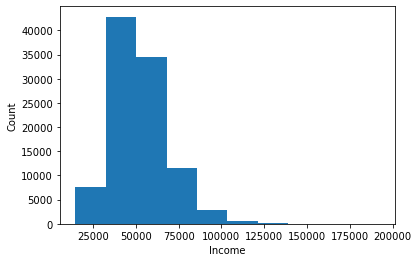

In [2]:
n = 100000
income = scipy.stats.lognorm.rvs(0.3, scale=50000, size=n)
plt.hist(income)
plt.xlabel("Income")
plt.ylabel("Count")

A Poisson regression usually uses a log link function, which means that the rate parameter $\mu$
is related to the linear regression via an exponential relationship, or

$$
\mu = e^{\mathbf{\beta}\mathbf{x} + \alpha}
$$

We can distribute the terms in the exponential to find
$$
\mu = e^{\alpha}e^{\beta x}
$$
and can therefore interpret $\alpha$ to be the log of the base rate when $x=0$,
and $\beta$ is the e-folding paramter. That is, if $\beta$ is $1/3$,
then $x$ must increase by 3 for $\mu$ to increase by one factor of $e$.

We can generate synthetic counts using this assumed functional relationship,
assuming one entitlement as the base rate, and $1/100000$ as the e-folding parameter.

In [3]:
beta = 1/100000
alpha = 0
mu =np.exp(income*beta + alpha)
counts = scipy.stats.poisson.rvs(mu=mu)

(array([6.1564e+04, 3.3912e+04, 3.8820e+03, 5.1000e+02, 9.6000e+01,
        2.6000e+01, 7.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1.15834051, 1.72658487, 2.29482923, 2.86307359, 3.43131795,
        3.99956231, 4.56780667, 5.13605103, 5.70429539, 6.27253975,
        6.8407841 ]),
 <a list of 10 Patch objects>)

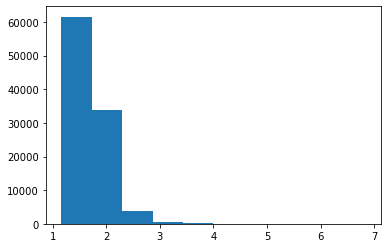

In [4]:
plt.hist(mu)

(array([4.9794e+04, 2.5489e+04, 1.4771e+04, 6.4590e+03, 2.4480e+03,
        7.5900e+02, 2.0300e+02, 5.8000e+01, 1.8000e+01, 1.0000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

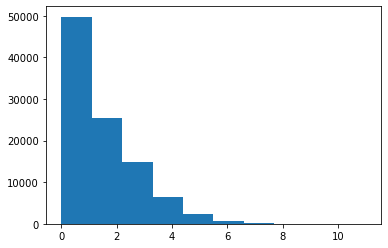

In [5]:
plt.hist(counts)

In [6]:
model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("regressor", sklearn.linear_model.PoissonRegressor(alpha=0.0,fit_intercept=True))
])

In [7]:
data =np.array([income,]).T
model.fit(data, counts)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', PoissonRegressor(alpha=0.0))])

In [8]:
s = model["scaler"]

In [9]:
r = model["regressor"]

The scaled variable $z$ is given by

$$
z = (x - u)/s
$$

We can solve for $x$ to get

$$
x = zs + u
$$
and substitute into the above linear equation for $\mu$:

$$
\mu = \beta x + \alpha = \beta (zs + u) + \alpha = \beta z s + \beta u + \alpha
$$

From the scaled variables, we can read off the unscaled versions:

$$ \hat{\alpha} = u \beta + \alpha $$
$$ \hat{\beta} = s \beta $$

We can solve these for $\alpha$ and $\beta$ in terms of the scaled versions:

$$
\beta = \frac{\hat{\beta}}{s}
$$
$$
\alpha = \hat{\alpha} - u \frac{\hat{\beta}}{s}
$$

$$
\hat{\alpha} = u_i \beta_i + \alpha
$$
$$
\hat{\beta_i} = s_i \beta_i
$$

In [10]:
beta = r.coef_[0]/s.scale_[0]
alpha = r.intercept_ - s.mean_[0] * beta
display(alpha,1./beta)

0.0002378445191587586

100195.13378377784

(array([6.1427e+04, 3.4026e+04, 3.9040e+03, 5.0800e+02, 9.9000e+01,
        2.6000e+01, 7.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1.15828443, 1.72413948, 2.28999453, 2.85584958, 3.42170463,
        3.98755969, 4.55341474, 5.11926979, 5.68512484, 6.2509799 ,
        6.81683495]),
 <a list of 10 Patch objects>)

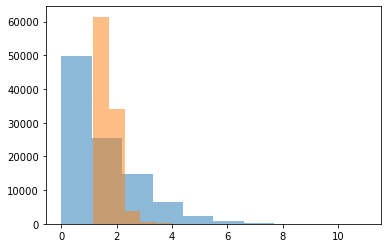

In [11]:
plt.hist(counts, alpha=0.5)
plt.hist(model.predict(data), alpha=0.5)

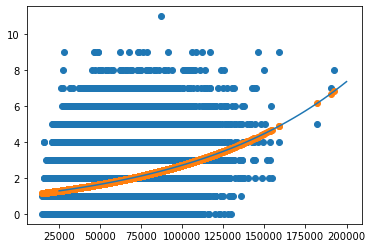

In [12]:
plt.scatter(data, counts)
plt.scatter(data, model.predict(data))
x = np.linspace(25000, 200000)
y = np.exp((beta * x + alpha))
plt.plot(x,y)